[Some code](https://github.com/giannisnik/som/blob/master/som.py) for SOM in Pytorch

In [111]:
import torch
import torch.nn as nn
import numpy as np
 

class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, alpha=None, sigma=None):
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.n_neurons = self.m * self.n
        # gain coefficient
        self.alpha = 0.3
        # correction
        self.sigma = max(m, n) / 2.0
        
        if alpha is not None:
            self.alpha = float(alpha)
        if sigma is not None:
            self.sigma = float(sigma)

        self.weights = torch.randn(self.n_neurons, dim)
        self.locations = torch.tensor(np.array(list(self.make_grid_locations_iter(m, n))), dtype=torch.int32)
        self.pdist = nn.PairwiseDistance(p=2)

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def make_grid_locations_iter(self, m, n):
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(self.n_neurons)],
                            key=lambda x: np.linalg.norm(vect-self.weights[x]))
            to_return.append(self.locations[min_index])

        return to_return

    def forward(self, x, learning_rate_op):
        dists = self.pdist(x, self.weights) # compare X with every column in W. columns is a batch dimension
        bmu_index = dists.min(0).indices # find the minimum distance
        bmu_loc = self.locations[bmu_index,:]
        
        alpha_op = self.alpha * learning_rate_op
        sigma_op = self.sigma * learning_rate_op

        diff = self.locations - bmu_loc # .unsqueeze(0).repeat(self.n_neurons, 1) - don't need to copy because broadcasting will do it (ref: https://numpy.org/doc/stable/user/basics.broadcasting.html)
        bmu_distance_squares = torch.sum(torch.pow(diff.float(), 2), 1) # array where for every neuron i: x_i ^2 + y_i ^2 -> d_i
        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2))) # e^{ -(d_i / sigma^2) }
        gain_coefficient = alpha_op * neighbourhood_func
        learning_rate_multiplier = gain_coefficient.repeat(self.dim, 1).T # copy to every dimension
        delta = torch.mul(learning_rate_multiplier, x - self.weights) # (x - self.weights) - uses broadcasting too

        self.weights += delta
    
    def forward_no_training(self, x):
        # torch.mul(self.weights, x)
        
        # find a location where the distance between x and m_i is the minimum 
        min_index = torch.linalg.vector_norm(x - self.weights, ord=2, dim=1).min(0).indices
        return self.locations[min_index]



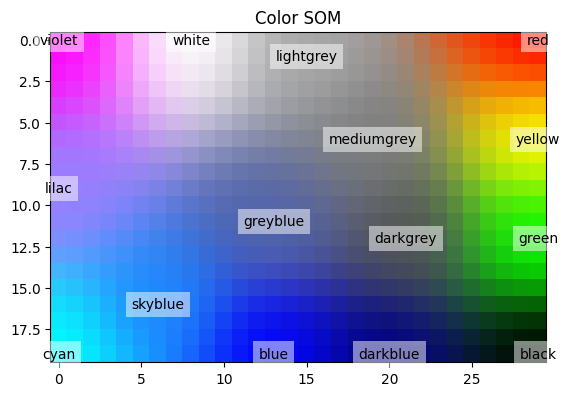

In [113]:
import numpy as np
import torch
import matplotlib.pyplot as plt



#Training inputs for RGBcolors
colors = torch.tensor([
    [0., 0., 0.],
    [0., 0., 1.],
    [0., 0., 0.5],
    [0.125, 0.529, 1.0],
    [0.33, 0.4, 0.67],
    [0.6, 0.5, 1.0],
    [0., 1., 0.],
    [1., 0., 0.],
    [0., 1., 1.],
    [1., 0., 1.],
    [1., 1., 0.],
    [1., 1., 1.],
    [.33, .33, .33],
    [.5, .5, .5],
    [.66, .66, .66]
])
color_names = [
    'black', 'blue', 'darkblue', 'skyblue',
    'greyblue', 'lilac', 'green', 'red',
    'cyan', 'violet', 'yellow', 'white',
    'darkgrey', 'mediumgrey', 'lightgrey'
]

#Train a 20x30 SOM with 100 iterations
m = 20
n = 30
n_iter = 100
som = SOM(m, n, 3)
for iter_no in range(n_iter):
    #Train with each vector one by one
    for i in range(len(colors)):
        learning_rate_op = 1.0 - iter_no/(1.0*n_iter)
        som(colors[i], learning_rate_op)

#Store a centroid grid for easy retrieval later on
centroid_grid = [[] for i in range(m)]
weights = som.get_weights()
locations = som.get_locations()
for i, loc in enumerate(locations):
    centroid_grid[loc[0]].append(weights[i].numpy())

#Get output grid
image_grid = centroid_grid

#Map colours to their closest neurons
mapped = som.map_vects(colors)

#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

In [107]:
diff = som.locations - som.locations[2]
bmu_distance_squares = torch.sum(torch.pow(diff.float(), 2), 1)
alpha_op = som.alpha
sigma_op = som.sigma
neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2)))
gain_coefficient = alpha_op * neighbourhood_func
learning_rate_multiplier = gain_coefficient.repeat(3, 1).T # copy to every dimension
learning_rate_multiplier

tensor([[0.2947, 0.2947, 0.2947],
        [0.2987, 0.2987, 0.2987],
        [0.3000, 0.3000, 0.3000],
        ...,
        [0.0037, 0.0037, 0.0037],
        [0.0030, 0.0030, 0.0030],
        [0.0024, 0.0024, 0.0024]])

In [92]:
colors[4] - som.weights

tensor([[-1.2270,  0.0626,  0.9206],
        [-0.7823, -0.1155,  1.1165],
        [-0.7320, -0.7437,  0.4646],
        ...,
        [ 0.0646, -0.9856,  1.4251],
        [-0.9042,  1.5224, -0.2556],
        [ 1.0932,  0.2546,  1.2975]])

In [110]:
torch.mul(learning_rate_multiplier, colors[4] - som.weights)

tensor([[ 2.8476e-01,  1.1216e-01,  9.0058e-02],
        [-1.7184e-01,  2.9289e-01,  1.5339e-01],
        [ 3.7323e-01,  6.7974e-01,  2.0371e-01],
        ...,
        [ 3.7015e-03,  1.1229e-03,  4.9877e-03],
        [ 1.6286e-03, -2.0631e-03, -1.5626e-03],
        [ 3.1188e-03, -5.6485e-04,  4.7253e-03]])

In [118]:
x = colors[4]
#torch.linalg.vector_norm(x - som.weights, ord=2, dim=0)
[np.linalg.norm(x-som.weights[i]) for i in range(som.n_neurons)]

[0.82303286,
 0.80750835,
 0.7745773,
 0.7380999,
 0.7392031,
 0.7938849,
 0.8591997,
 0.89976496,
 0.911686,
 0.88547707,
 0.81920683,
 0.712572,
 0.59291553,
 0.5001052,
 0.44889763,
 0.42617843,
 0.4124883,
 0.39671072,
 0.3787302,
 0.36676422,
 0.37726265,
 0.43034837,
 0.5319457,
 0.66077524,
 0.78248054,
 0.8735569,
 0.9312105,
 0.96530014,
 0.985589,
 0.995007,
 0.81045115,
 0.79551923,
 0.76360637,
 0.7298089,
 0.73228943,
 0.7849013,
 0.8479817,
 0.8869989,
 0.89519364,
 0.86823255,
 0.79879993,
 0.68962425,
 0.57103294,
 0.48282596,
 0.43699774,
 0.41827035,
 0.40444547,
 0.38509557,
 0.363094,
 0.34847885,
 0.35647383,
 0.40481064,
 0.5015965,
 0.6303478,
 0.7566275,
 0.85251975,
 0.9121935,
 0.9459977,
 0.96535134,
 0.97331214,
 0.77888006,
 0.7646341,
 0.73699236,
 0.71107954,
 0.71689516,
 0.76355994,
 0.81967765,
 0.8545911,
 0.85864764,
 0.82779634,
 0.7568304,
 0.65245044,
 0.5443222,
 0.46594965,
 0.42503685,
 0.40565473,
 0.38781443,
 0.36380157,
 0.33915538,
 0.3248

In [120]:
np.linalg.norm(x-som.weights[0])

0.82303286

In [121]:
torch.linalg.vector_norm(x - som.weights[0], ord=2)

tensor(0.8230)

In [123]:
torch.linalg.vector_norm(x - som.weights, ord=2, dim=1)

tensor([0.8230, 0.8075, 0.7746, 0.7381, 0.7392, 0.7939, 0.8592, 0.8998, 0.9117,
        0.8855, 0.8192, 0.7126, 0.5929, 0.5001, 0.4489, 0.4262, 0.4125, 0.3967,
        0.3787, 0.3668, 0.3773, 0.4303, 0.5319, 0.6608, 0.7825, 0.8736, 0.9312,
        0.9653, 0.9856, 0.9950, 0.8105, 0.7955, 0.7636, 0.7298, 0.7323, 0.7849,
        0.8480, 0.8870, 0.8952, 0.8682, 0.7988, 0.6896, 0.5710, 0.4828, 0.4370,
        0.4183, 0.4044, 0.3851, 0.3631, 0.3485, 0.3565, 0.4048, 0.5016, 0.6303,
        0.7566, 0.8525, 0.9122, 0.9460, 0.9654, 0.9733, 0.7789, 0.7646, 0.7370,
        0.7111, 0.7169, 0.7636, 0.8197, 0.8546, 0.8586, 0.8278, 0.7568, 0.6525,
        0.5443, 0.4659, 0.4250, 0.4057, 0.3878, 0.3638, 0.3392, 0.3248, 0.3328,
        0.3770, 0.4678, 0.5951, 0.7262, 0.8285, 0.8909, 0.9227, 0.9374, 0.9429,
        0.7208, 0.7100, 0.6913, 0.6773, 0.6877, 0.7271, 0.7734, 0.8016, 0.7999,
        0.7640, 0.6931, 0.5981, 0.5052, 0.4386, 0.4012, 0.3789, 0.3569, 0.3313,
        0.3092, 0.2994, 0.3088, 0.3488, 

In [124]:
torch.linalg.vector_norm(x - som.weights, ord=2, dim=1).min(0)

torch.return_types.min(
values=tensor(0.0052),
indices=tensor(343))

Let's reproduce an experiment from [Kohonen's paper](https://sci2s.ugr.es/keel/pdf/algorithm/articulo/1990-Kohonen-PIEEE.pdf). It's about random dots that become organized as a curve that evenly takes the whole space.

In [147]:
# v_x, v_y, v_z \in [0,1]
def vector_to_barycentric_coord(v):
    v /= v.sum(dim=1, keepdim=True)
    return v

In [161]:
# Generate vertices of an equilateral triangle
triangle_side = 1.0
half_height = np.sqrt(3) / 2 * triangle_side
triangle_points = np.array([[0, 0], 
                            [triangle_side, 0], 
                            [triangle_side / 2, half_height]])

def plot_triangle_and_data(data):
    # Plotting the equilateral triangle
    plt.figure(figsize=(6, 6))
    plt.fill(triangle_points[:, 0], triangle_points[:, 1], 'b', alpha=0.3, label="Equilateral Triangle")

    # Plotting the random vectors inside the triangle
    origin = np.array([0, 0])  # origin point for vectors
    line_segments_x = []
    line_segments_y = []
    for i in range(data.shape[0]):
        vec = data[i].numpy()
        if i < data.shape[0] - 1:
            next_vec = data[i+1].numpy()
            line_segments_x.append(vec[0])
            line_segments_x.append(next_vec[0])
            line_segments_y.append(vec[1])
            line_segments_y.append(next_vec[1])
        # plt.plot(vec, next_vec, color='r')
        # bold points
        #plt.plot(vec[0], vec[1], 'bo') 
        # vector line
        #plt.quiver(origin[0], origin[1], vec[0], vec[1], angles='xy', scale_units='xy', scale=1, color='g', alpha=0.6)

    # connection between one point and the next
    plt.plot(line_segments_x, line_segments_y, color='r')

    # Set plot limits and labels
    plt.xlim(-0.25, 1.25)
    plt.ylim(-0.25, 1.25)
    #plt.gca().set_aspect('equal', adjustable='box')
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    #plt.legend()
    plt.title('Equilateral Triangle and Random Vectors Inside')
    plt.grid(True)
    plt.show()

In [150]:
def random_barycentric_coordinates(n_points):
    barycentric_coords = torch.rand(n_points, 3)
    barycentric_coords /= barycentric_coords.sum(dim=1, keepdim=True)
    return barycentric_coords

Just 10 random points in a equilateral triangle. First, a 3D vector created from three uniformly distributed values in a single unit cube. Then they are converted into 2D points (blue balls) (or we can think about them as 2D vectors as depicted by a green arrows but that's all fiction hehe). This conversion uses barycentric coordinate system and thus all 3D values from [0,1] interval lay inside the triangle.

In [170]:

# Generate 10 random points inside the triangle using barycentric coordinates
n_points = 100
bary_coords = random_barycentric_coordinates(n_points)

# bary_coords = torch.tensor([
#     [0.5,0.5,0],
#     [0.33,0.33,0.33],
#     [0,0,1],
# ], dtype=torch.float32)

# Convert barycentric coordinates to 2D points inside the triangle
vectors_in_triangle = torch.matmul(bary_coords, torch.tensor(triangle_points).float())



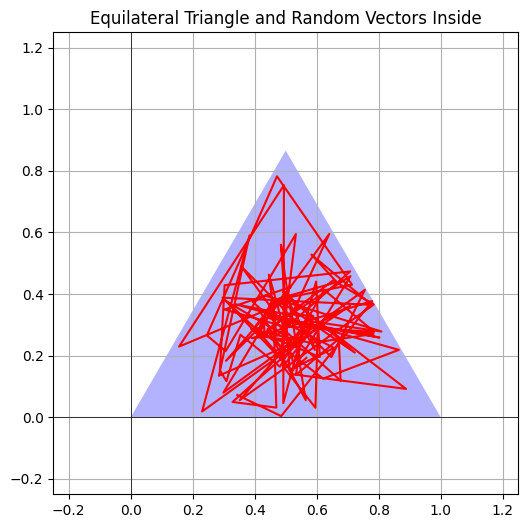

In [171]:
vectors_in_triangle.shape
plot_triangle_and_data(vectors_in_triangle)

In [156]:
bary_coords

tensor([[0.4465, 0.0711, 0.4824],
        [0.7557, 0.0715, 0.1727],
        [0.3656, 0.3015, 0.3329],
        ...,
        [0.3734, 0.3988, 0.2278],
        [0.3984, 0.0669, 0.5347],
        [0.0859, 0.2910, 0.6231]])

In [181]:

n_points = 100

m = 100
n = 1
n_iter = 5000
som = SOM(m, n, 3)


for iter_no in range(n_iter):
    bary_coords = random_barycentric_coordinates(n_points)
    data = bary_coords
    #Train with each vector one by one
    for i in range(len(data)):
        learning_rate_op = 1.0 - iter_no/(1.0*n_iter)
        som(data[i], learning_rate_op)


In [182]:
w = som.get_weights()
points_in_triangle = torch.matmul(w, torch.tensor(triangle_points).float())

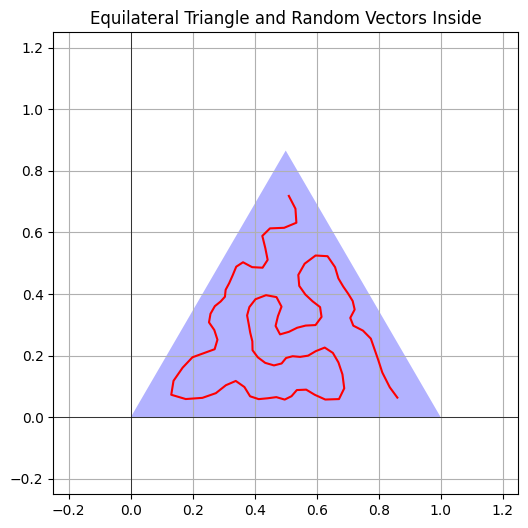

In [183]:
plot_triangle_and_data(points_in_triangle)

In [65]:

#Store a centroid grid for easy retrieval later on
weights = som.get_weights()
locations = som.get_locations()

#Get output grid
image_grid = centroid_grid

#Map colours to their closest neurons
mapped = som.map_vects(torch.Tensor(colors))

#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
plt.show()

RuntimeError: The size of tensor a (3) must match the size of tensor b (2) at non-singleton dimension 0